# Notes

Build based on this [tutorial](http://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/SCENIC%20Protocol%20-%20Case%20study%20-%20Cancer%20data%20sets.html)

# Load Modules

In [1]:
import os, glob, re, pickle
from functools import partial, reduce
import operator as op
from cytoolz import compose
from typing import List, Dict

import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import zscore
import scanpy as sc
import anndata as ad
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss
from pyscenic.aucell import aucell

/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/sc/arion/work/wangw32/conda-env/envs/py310/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) ->

In [2]:
from typing import Dict


def tmp(motif_table: pd.DataFrame, regulon: str):
    for i in motif_table.loc[regulon,'TargetGenes'].values:
        for j in i:
            yield j[0]

            
def write_top_regulon(top_reg: Dict, name: str, motif_table: pd.DataFrame) -> None:
    with open(f'{name}_top_regulon_by_condition.txt', 'w') as fhd:
        for k, v in top_reg.items():
            v_text = "\t".join(v)
            fhd.write(f'{k}\t{v_text}\n')
    
    topreg_list = list(reduce(lambda x, y: list(set(x) | set(y)), top_reg.values()))
    with open(f'{name}_top_regulon.txt', 'w') as fhd:
        fhd.write('\t'.join(topreg_list) + '\n')
    
    with open(f'{name}_top_regulon_targets.txt', 'w') as fhd:
        for regulon in topreg_list:
            text = "\t".join(list(tmp(motif_table = motif_table, regulon = regulon)))
            fhd.write(f'{regulon}:\t{text}\n')
        

# global settings

In [3]:
# Set maximum number of jobs
sc.settings.njobs = 4

In [4]:
RESOURCES_FOLDERNAME = '../'
RESULTS_FOLDERNAME = "./results/"
FIGURES_FOLDERNAME = "./figures/"
AUXILLIARIES_FOLDERNAME = '/hpc/users/wangw32/source/bySpecies/mm10/cisTarget_databases'

In [5]:
os.makedirs(RESULTS_FOLDERNAME, exist_ok=True)
os.makedirs(FIGURES_FOLDERNAME, exist_ok=True)

In [6]:
# Ranking databases. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                       ['mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
                       'mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
                       ]))
# Motif annotations. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
MOTIF_ANNOTATIONS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl')

In [7]:
DATASET_ID = 'stereo_seq'

In [8]:
# Downloaded expression matrix from GEO on 13 JUN 2019 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361).
COUNTS_MTX_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'stereo_seq_filtered_sct.txt')
# Downloaded metadata from http://linnarssonlab.org/cortex/ on 13 JUN 2019
METADATA_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'stereo_seq_filtered_meta.txt')

MM_TFS_FNAME = os.path.join(RESULTS_FOLDERNAME, 'mm_tfs.txt')

# Output file
COUNTS_QC_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.qc.counts.csv'.format(DATASET_ID))
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adjacencies.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.auc.csv'.format(DATASET_ID))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.bin.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.loom'.format(DATASET_ID))

## download database file

In [9]:
%%bash
# wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather -O mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
# wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather -O mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
# wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl -O motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl

## Create list of M. musculus transcription factors

In [10]:
pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')

/tmp/ipykernel_18738/1731902578.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')


In [11]:
mm_tfs = pd_motifs.gene_name.unique()
len(mm_tfs)

1412

In [12]:
with open(MM_TFS_FNAME, 'wt') as f:
    f.write('\n'.join(mm_tfs) + '\n')

# Load data

In [13]:
df_counts = pd.read_csv(COUNTS_MTX_FNAME, sep=' ', index_col=0)
df_counts.shape

(19330, 26621)

In [14]:
df_counts.head()

,E12_E1S3_100034,E12_E1S3_100035,E12_E1S3_100191,E12_E1S3_100256,E12_E1S3_100264,E12_E1S3_100337,E12_E1S3_100346,E12_E1S3_100461,E12_E1S3_100502,E12_E1S3_100532,...,E16_E2S7_326320,E16_E2S7_326323,E16_E2S7_326324,E16_E2S7_326325,E16_E2S7_326329,E16_E2S7_326357,E16_E2S7_326359,E16_E2S7_326384,E16_E2S7_326391,E16_E2S7_326412
0610005C13Rik,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0610009B22Rik,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0610009O20Rik,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0610010F05Rik,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0610010K14Rik,0.0,0.0,0.0,0.0,1.386294,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0


In [15]:
df_metadata = pd.read_csv(METADATA_FNAME, sep=' ', index_col=0)
df_metadata.head()

,orig.ident,nCount_Spatial,nFeature_Spatial,sample,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,SCT_snn_res.0.8,annot,...,dpt_niche_rank,dpt_niche_norm,lisa_dpt_niche,lisa_dpt_sct,x,y,niche_NTScore,cell_NTScore,env_group,stage_annot_env_group
E12_E1S3_100034,E12,815,392,E12_E1S3,795,385,5,6,6,Fibro,...,5655,0.211349,0.091377,0.588423,15940.0,18584.0,0.886360,0.801228,high,E12_Fibro_high
E12_E1S3_100035,E12,549,270,E12_E1S3,713,268,5,6,6,Fibro,...,6498,0.242860,0.257227,1.420378,15942.0,18623.0,0.908583,0.867745,high,E12_Fibro_high
E12_E1S3_100191,E12,897,411,E12_E1S3,866,404,5,9,9,Endo,...,6110,0.228357,0.177693,1.330522,15965.0,18619.0,0.907789,0.838498,high,E12_Endo_high
E12_E1S3_100256,E12,562,268,E12_E1S3,722,267,5,6,6,Fibro,...,12505,0.467404,1.193955,2.371677,15969.0,18717.0,0.909106,0.908074,high,E12_Fibro_high
E12_E1S3_100264,E12,512,243,E12_E1S3,687,239,5,6,6,Fibro,...,11710,0.437687,0.794561,1.983908,15974.0,18692.0,0.909106,0.899043,high,E12_Fibro_high


In [16]:
df_metadata.shape

(26621, 28)

# Create AnnData

In [17]:
adata = sc.AnnData(X=df_counts.T.sort_index())
adata.obs = df_metadata.sort_index()
adata.var_names_make_unique()
df_counts_qc = adata.to_df()
adata

AnnData object with n_obs × n_vars = 26621 × 19330
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'sample', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'annot', 'nCount_Niche', 'nFeature_Niche', 'annot_niche_max', 'timepoint', 'dpt_sct', 'AP', 'DV', 'dpt_niche', 'dpt_niche_rank', 'dpt_niche_norm', 'lisa_dpt_niche', 'lisa_dpt_sct', 'x', 'y', 'niche_NTScore', 'cell_NTScore', 'env_group', 'stage_annot_env_group'

In [18]:
# df_counts_qc.to_csv(COUNTS_QC_MTX_FNAME) # time consuming, skip this when re-run

# SCENIC

## grn

In [19]:
print(COUNTS_QC_MTX_FNAME)
print(MM_TFS_FNAME)
print(ADJACENCIES_FNAME)

./results/stereo_seq.qc.counts.csv
./results/mm_tfs.txt
./results/stereo_seq.adjacencies.tsv


In [20]:
%%bash  -s "$COUNTS_QC_MTX_FNAME" "$MM_TFS_FNAME" "$ADJACENCIES_FNAME"

# source ~/.bash_profile
# conda activate py310
# pyscenic grn $1 $2 -o $3 --num_workers 4

## ctx

In [21]:
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)

In [22]:
print(ADJACENCIES_FNAME)
print(DBS_PARAM)
print(MOTIF_ANNOTATIONS_FNAME)
print(COUNTS_QC_MTX_FNAME)
print(MOTIFS_FNAME)

./results/stereo_seq.adjacencies.tsv
/hpc/users/wangw32/source/bySpecies/mm10/cisTarget_databases/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather /hpc/users/wangw32/source/bySpecies/mm10/cisTarget_databases/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
/hpc/users/wangw32/source/bySpecies/mm10/cisTarget_databases/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl
./results/stereo_seq.qc.counts.csv
./results/stereo_seq.motifs.csv


In [23]:
%%bash -s "$ADJACENCIES_FNAME" "$DBS_PARAM" "$MOTIF_ANNOTATIONS_FNAME" "$COUNTS_QC_MTX_FNAME" "$MOTIFS_FNAME"

# source ~/.bash_profile
# conda activate py310

# pyscenic ctx $1 $2 --annotations_fname $3 --expression_mtx_fname $4 --output $5 --num_workers 4

## regulons

In [24]:
df_motifs = load_motifs(MOTIFS_FNAME)
df_motifs.head()

Enrichment                                  \
                                       AUC       NES MotifSimilarityQvalue   
TF   MotifID                                                                 
Ahr  homer__TBGCACGCAA_Arnt_Ahr   0.101550  3.471391          0.000000e+00   
Alx3 metacluster_161.27           0.084426  3.078635          5.691350e-06   
     metacluster_161.28           0.083597  3.031447          3.548630e-07   
     metacluster_161.8            0.089025  3.340309          2.230260e-07   
Alx4 metacluster_146.2            0.115201  4.149857          0.000000e+00   

                                                     \
                                OrthologousIdentity   
TF   MotifID                                          
Ahr  homer__TBGCACGCAA_Arnt_Ahr            0.731677   
Alx3 metacluster_161.27                    0.918367   
     metacluster_161.28                    0.918367   
     metacluster_161.8                     0.918367   
Alx4 metacluster_146.2                     0.929825   

                                                                                    \
                                                                        Annotation   
TF   MotifID                                                                         
Ahr  homer__TBGCACGCAA_Arnt_Ahr  gene is orthologous to ENSG00000106546 in H. s...   
Alx3 metacluster_161.27          motif similar to taipale_cyt_meth__ALX3_NTCGTT...   
     metacluster_161.28          motif similar to taipale_cyt_meth__ALX3_NTCGTT...   
     metacluster_161.8           gene is orthologous to ENSG00000156150 in H. s...   
Alx4 metacluster_146.2           gene is orthologous to ENSG00000052850 in H. s...   

                                                                                    \
                                                                           Context   
TF   MotifID                                                                         
Ahr  homer__TBGCACGCAA_Arnt_Ahr  (mm10_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   
Alx3 metacluster_161.27          (mm10_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   
     metacluster_161.28          (mm10_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   
     metacluster_161.8           (mm10_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   
Alx4 metacluster_146.2           (mm10_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   

                                                                                    \
                                                                       TargetGenes   
TF   MotifID                                                                         
Ahr  homer__TBGCACGCAA_Arnt_Ahr  [(Thsd1, 1.8384280052251696), (Gm7854, 0.60408...   
Alx3 metacluster_161.27          [(Gamt, 0.5198656852380183), (Cyth1, 0.8240496...   
     metacluster_161.28          [(Nek3, 0.4380351758947928), (Dock1, 1.6403889...   
     metacluster_161.8           [(Dock1, 1.6403889100511195), (Cyth1, 0.824049...   
Alx4 metacluster_146.2           [(Igf2, 0.9877908974786166), (Alx4, 1.0), (Tbc...   

                                           
                                RankAtMax  
TF   MotifID                               
Ahr  homer__TBGCACGCAA_Arnt_Ahr       681  
Alx3 metacluster_161.27              1875  
     metacluster_161.28              1028  
     metacluster_161.8                427  
Alx4 metacluster_146.2                110

In [25]:
from copy import deepcopy

In [26]:
df_motifs_ = deepcopy(df_motifs)
df_motifs_.columns = df_motifs_.columns.droplevel(0)

In [27]:
def contains(*elems):
    def f(context):
        return any(elem in context for elem in elems)
    return f


db_names=('mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings',
                       'mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings',)

In [28]:
df_motifs_ = df_motifs_[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), df_motifs_.Context), dtype=bool) & \
        np.fromiter(map(contains(*db_names), df_motifs_.Context), dtype=bool) & \
        np.fromiter(map(contains('activating'), df_motifs_.Context), dtype=bool)]

In [29]:

def gene_list_tmp():
    for i in df_motifs_.loc['Bcl6','TargetGenes'].values:
        for j in i:
            yield j[0]

            
gene_list = list(gene_list_tmp())

/tmp/ipykernel_18738/2956257398.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in df_motifs_.loc['Bcl6','TargetGenes'].values:


In [30]:
gene_list

['Plk2',
 'Nsun7',
 'Mpo',
 'Wnt6',
 'Sel1l3',
 'Mvb12a',
 'Smim5',
 'Bcl6',
 'Tesc',
 'Gja5',
 'Nsun7',
 'Txnl4b',
 'Dusp12',
 'Myh8',
 'Tmem63c',
 'Bcl6',
 'Sfmbt2',
 'Acacb',
 'Camk2g',
 'Tesc',
 'Phf2',
 'Wnt6',
 'Tesc',
 'Gja5',
 'Nsun7',
 'Txnl4b',
 'Dusp12',
 'Myh8',
 'Tmem63c',
 'Bcl6',
 'Sfmbt2',
 'Acacb',
 'Camk2g',
 'Tesc',
 'Phf2',
 'Wnt6',
 'Bcl6',
 'Itga8',
 'Stk17b',
 'S100a9',
 'Sel1l3',
 'Itgb5',
 'Caskin2',
 'Wnt6',
 'Lig4',
 'Nsun7',
 'Ldlr',
 'Itgb5',
 'Slc9a3r2',
 'Ndrg2',
 'Sult2b1',
 'S100a8',
 'Rbms2',
 'Acacb',
 'Smim5',
 'Lsp1']

In [31]:
regulons_ = df2regulons(df_motifs_)
regulons_ = list(map(lambda r: r.rename(r.transcription_factor), regulons_))

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [32]:
def derive_regulons(motifs, db_names=('mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings',
                       'mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings',)):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10,
                           df2regulons(motifs[(motifs['NES'] >= 3.0)
                                              & (
                                                  (motifs['Annotation'] == 'gene is directly annotated')
                                                  | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                    # & motifs['Annotation'].str.endswith('which is directly annotated for motif')  
                                                    )
                                              )
                                                                     ]
                                      )
                          )
                   )
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))

In [33]:
#regulons = derive_regulons(df_motifs)

In [34]:
regulons = regulons_[:]

In [35]:
sum(['Sox2' in x for x in regulons])

9

In [36]:
sum(['Pax6' in x for x in regulons])

4

## aucell

In [37]:
%%time

# auc_mtx = aucell(df_counts_qc, regulons, num_workers=4)
# auc_mtx.to_csv(AUCELL_MTX_FNAME)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [38]:
AUCELL_MTX_FNAME

'./results/stereo_seq.auc.csv'

In [39]:
auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)
auc_mtx.head()

,Ahr,Alx1,Alx3,Alx4,Ar,Arid3a,Arntl2,Arx,Atf1,Atf3,...,Zfp821,Zfp874b,Zfp941,Zfp944,Zfp979,Zic1,Zkscan14,Zkscan16,Zscan20,Zxdc
Cell,,,,,,,,,,,,,,,,,,,,,
E12_E1S3_100034,0.0,0.014262,0.009032,0.038966,0.0,0.001760,0.0,0.000000,0.0,0.134952,...,0.0,0.000000,0.0,0.0,0.0,0.051056,0.045712,0.017288,0.0,0.0
E12_E1S3_100035,0.0,0.017741,0.017087,0.000000,0.0,0.003681,0.0,0.000000,0.0,0.167847,...,0.0,0.003940,0.0,0.0,0.0,0.064695,0.062440,0.026075,0.0,0.0
E12_E1S3_100191,0.0,0.009400,0.009933,0.026062,0.0,0.001426,0.0,0.000000,0.0,0.129891,...,0.0,0.000000,0.0,0.0,0.0,0.088422,0.042828,0.015757,0.0,0.0
E12_E1S3_100256,0.0,0.017928,0.017399,0.000000,0.0,0.003750,0.0,0.000000,0.0,0.168128,...,0.0,0.004096,0.0,0.0,0.0,0.048256,0.062728,0.091552,0.0,0.0
E12_E1S3_100264,0.0,0.019671,0.019565,0.042947,0.0,0.004231,0.0,0.080958,0.0,0.176000,...,0.0,0.005547,0.0,0.0,0.0,0.049611,0.066910,0.028448,0.0,0.0


In [40]:
'Sox2' in auc_mtx.columns

True

In [41]:
'Pax6' in auc_mtx.columns

True

In [42]:
auc_mtx.shape

(26621, 304)

## timepoints & normalization

In [43]:
auc_mtx_e14 = auc_mtx.loc[adata.obs['orig.ident'] == 'E14',:]
auc_mtx_e16 = auc_mtx.loc[adata.obs['orig.ident'] == 'E16',:]

In [44]:
def auc_matrix_normalization(auc_mtx: pd.DataFrame) -> pd.DataFrame:
    auc_mtx_zscore = auc_mtx.apply(zscore, 0)
    auc_mtx_zscore = auc_mtx_zscore.loc[:, np.isnan(auc_mtx_zscore.values).sum(0) != auc_mtx.shape[0]]
    
    return auc_mtx_zscore

In [45]:
auc_mtx_zscore = auc_matrix_normalization(auc_mtx)
auc_mtx_e14_zscore = auc_matrix_normalization(auc_mtx_e14)
auc_mtx_e16_zscore = auc_matrix_normalization(auc_mtx_e16)

In [46]:
auc_mtx_zscore_dict = {'all': auc_mtx_zscore,
                       'E14': auc_mtx_e14_zscore,
                       'E16': auc_mtx_e16_zscore}

## Regulon specificity scores (RSS) across predicted cell types

In [150]:
RSS_topN = 30

### cell type across all samples

In [151]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [152]:
rss_cellType = regulon_specificity_scores( auc_mtx, adata.obs['annot'] )

In [153]:
rss_cellType

,Ahr,Alx1,Alx3,Alx4,Ar,Arid3a,Arntl2,Arx,Atf1,Atf3,...,Zfp821,Zfp874b,Zfp941,Zfp944,Zfp979,Zic1,Zkscan14,Zkscan16,Zscan20,Zxdc
Fibro,0.179662,0.239581,0.270377,0.321801,0.204910,0.231797,0.205198,0.203123,0.167445,0.253616,...,0.189076,0.207196,0.184511,0.172000,0.194614,0.233553,0.254742,0.251543,0.173756,0.180484
Endo,0.179675,0.201129,0.212713,0.239739,0.185972,0.206924,0.192210,0.186707,0.167445,0.208851,...,0.184522,0.189738,0.176839,0.170618,0.186487,0.199403,0.209616,0.207179,0.174185,0.178064
GABA,0.180785,0.239177,0.239595,0.212564,0.199504,0.222780,0.216999,0.221387,0.170254,0.246354,...,0.194808,0.229955,0.189216,0.171767,0.182523,0.255668,0.238965,0.237841,0.184807,0.175647
GluNeuB,0.176310,0.281463,0.284814,0.225302,0.206753,0.250693,0.229453,0.242848,0.168489,0.297922,...,0.203931,0.244960,0.191432,0.169847,0.196391,0.291259,0.284566,0.283700,0.191176,0.182537
Ery,0.177894,0.227016,0.231757,0.209671,0.195936,0.218364,0.208513,0.210876,0.168377,0.235867,...,0.191703,0.206785,0.188125,0.173198,0.184223,0.229842,0.232166,0.228120,0.180957,0.180918
RGC,0.169860,0.263516,0.280708,0.234556,0.220077,0.240716,0.239645,0.230555,0.168977,0.294200,...,0.194991,0.222923,0.182815,0.171235,0.193959,0.251996,0.278124,0.279419,0.179225,0.187384
NeuB,0.176107,0.252894,0.260238,0.221557,0.213232,0.233990,0.219242,0.221980,0.168904,0.265294,...,0.196382,0.226167,0.179925,0.169076,0.204523,0.249505,0.255477,0.257191,0.182469,0.178368
GluNeu,0.191463,0.412732,0.395643,0.285888,0.248020,0.331717,0.309046,0.323048,0.168490,0.431533,...,0.227059,0.326026,0.215847,0.171208,0.199641,0.504480,0.399078,0.389885,0.205646,0.186001
Basal,0.177259,0.181488,0.185377,0.209042,0.176601,0.176631,0.181515,0.174398,0.167445,0.183102,...,0.176409,0.175950,0.175204,0.173987,0.179684,0.180141,0.183134,0.182391,0.170172,0.171141
GlioB,0.170281,0.223354,0.235163,0.209805,0.204716,0.217568,0.211240,0.204035,0.170803,0.233898,...,0.185430,0.212792,0.178468,0.173613,0.203908,0.227665,0.231907,0.232418,0.174333,0.179004


In [154]:
rss_cellType.to_csv('RSS_by_cell_type_all_stage.csv')

#### RSS panel plot with all cell types

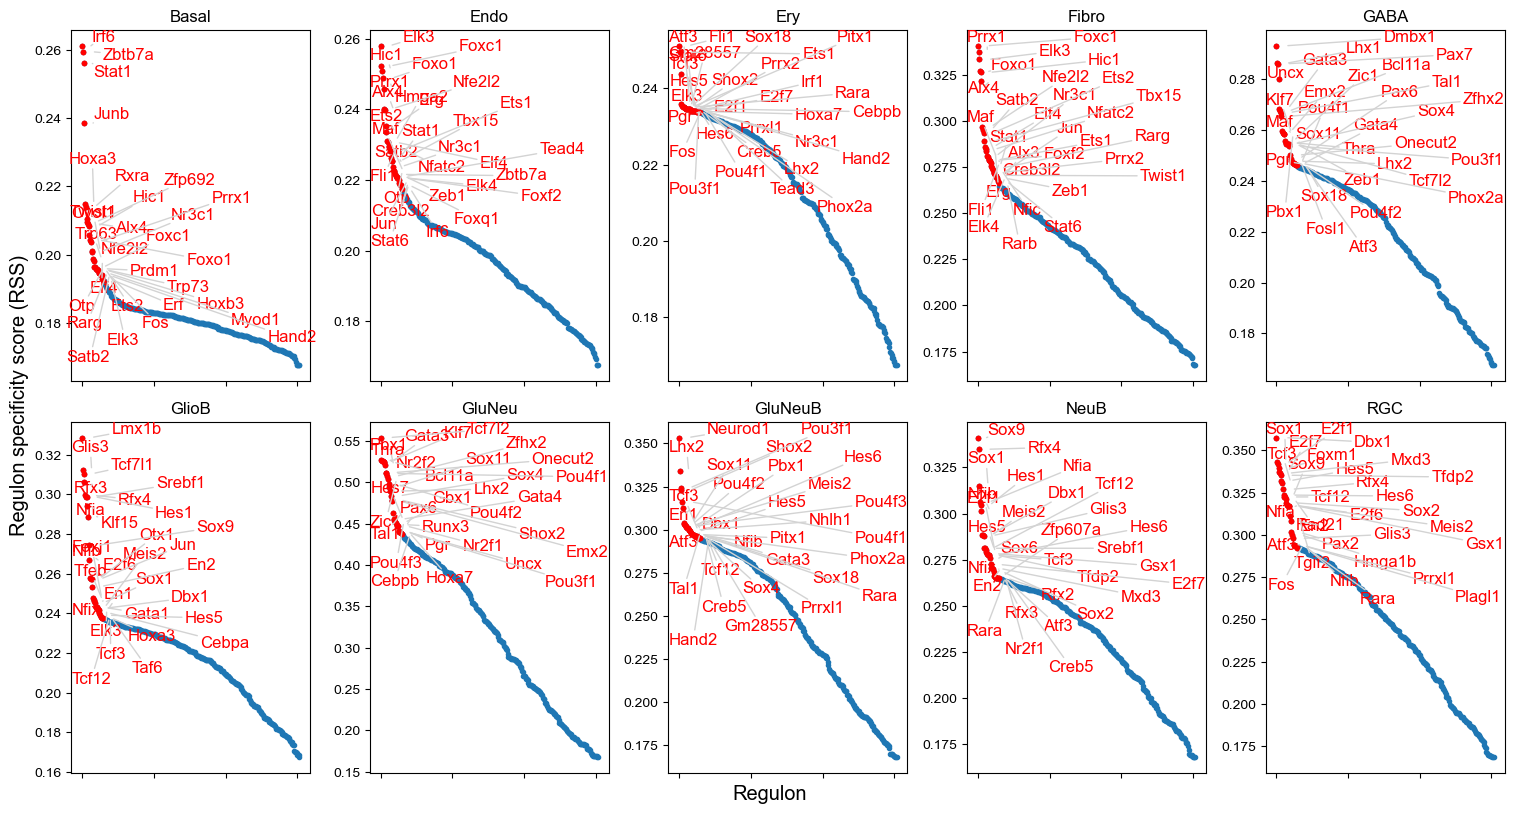

In [155]:
cats = sorted(list(set(adata.obs['annot'])))
topreg = {}


fig = plt.figure(figsize=(15, 8))
for num_, c in enumerate(cats):
    num = num_ + 1
    # knee point
    # x_ = range(1, rss_cellType.shape[1]+1)
    # y_ = sorted(rss_cellType.iloc[num_,:].values, reverse=True)
    # kn = KneeLocator(x_, y_, curve='convex', direction='decreasing')
    # knee_point = kn.knee
    # topreg[c] = list(rss_cellType.T[c].sort_values(ascending=False)[:knee_point].index)
    
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=RSS_topN, max_n=None, ax=ax)
    # plot_rss(rss_cellType, c, top_n=knee_point, max_n=None, ax=ax)
    # ax.vlines(knee_point, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed')
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig(f"All_sample_cellType_RSS_top_{RSS_topN}.pdf", dpi=600, bbox_inches = "tight")

#### Select the top regulons from each cell type

In [156]:
topreg = {}
for i,c in enumerate(cats):
    topreg[c] = list(rss_cellType.T[c].sort_values(ascending=False)[:RSS_topN].index)

In [157]:
topreg

{'Basal': ['Irf6',
  'Zbtb7a',
  'Stat1',
  'Junb',
  'Hoxa3',
  'Rxra',
  'Ovol1',
  'Zfp692',
  'Alx4',
  'Hic1',
  'Nfe2l2',
  'Foxo1',
  'Prrx1',
  'Twist1',
  'Nr3c1',
  'Trp63',
  'Elf4',
  'Foxc1',
  'Otp',
  'Prdm1',
  'Ets2',
  'Trp73',
  'Hoxb3',
  'Rarg',
  'Myod1',
  'Fos',
  'Satb2',
  'Hand2',
  'Elk3',
  'Erf'],
 'Endo': ['Elk3',
  'Foxc1',
  'Hic1',
  'Foxo1',
  'Prrx1',
  'Nfe2l2',
  'Alx4',
  'Erg',
  'Ets2',
  'Hmga2',
  'Elf4',
  'Fli1',
  'Nfatc2',
  'Ets1',
  'Stat1',
  'Tbx15',
  'Satb2',
  'Nr3c1',
  'Otp',
  'Maf',
  'Zbtb7a',
  'Zeb1',
  'Tead4',
  'Foxf2',
  'Elk4',
  'Jun',
  'Creb3l2',
  'Stat6',
  'Foxq1',
  'Irf6'],
 'Ery': ['Fli1',
  'Ets1',
  'Elk3',
  'Atf3',
  'Gm28557',
  'Sox18',
  'Pitx1',
  'Rara',
  'Stat6',
  'Shox2',
  'Cebpb',
  'Hes5',
  'Tcf3',
  'Irf1',
  'Prrx2',
  'Pou3f1',
  'E2f7',
  'Hes6',
  'Fos',
  'Creb5',
  'E2f1',
  'Pgr',
  'Prrxl1',
  'Pou4f1',
  'Hoxa7',
  'Nr3c1',
  'Hand2',
  'Lhx2',
  'Phox2a',
  'Tead3'],
 'Fibro': ['Foxc1

In [158]:
write_top_regulon(top_reg = topreg, name=f'All_cells_top{RSS_topN}', motif_table = df_motifs_)

/tmp/ipykernel_18738/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


In [96]:
topreg_list = reduce(lambda x, y: list(set(x) | set(y)), topreg.values())

In [97]:
topreg_list

['Atf3',
 'Tcf7l2',
 'Lhx1',
 'Pou4f2',
 'Nfib',
 'Ets1',
 'Zbtb7a',
 'E2f1',
 'Prrx1',
 'Klf15',
 'Satb2',
 'Stat6',
 'Pbx1',
 'Pax7',
 'Rfx4',
 'Tcf7l1',
 'Junb',
 'Ets2',
 'Srebf1',
 'Lhx2',
 'Uncx',
 'Lmx1b',
 'Sox18',
 'Rfx3',
 'Pou3f1',
 'Elk3',
 'Gm28557',
 'En1',
 'Stat1',
 'Nfe2l2',
 'Erg',
 'Foxc1',
 'Sox9',
 'Dbx1',
 'Tcf12',
 'Fli1',
 'Sox1',
 'E2f7',
 'Tbx15',
 'Zfp692',
 'Bcl11a',
 'Pitx1',
 'Hes1',
 'Pou4f3',
 'Onecut2',
 'Tfdp2',
 'Hmga2',
 'Hes5',
 'Klf7',
 'Gata3',
 'Meis2',
 'Nr2f2',
 'Tal1',
 'Pou4f1',
 'Rxra',
 'Foxm1',
 'Tcf3',
 'Foxo1',
 'Shox2',
 'Rara',
 'Glis3',
 'Sox11',
 'Hoxa3',
 'Emx2',
 'Ovol1',
 'Mxd3',
 'Alx4',
 'Irf6',
 'Hic1',
 'Zfhx2',
 'Dmbx1',
 'Nfia',
 'Thra',
 'Neurod1']

#### mean activity across each groups

In [58]:
all_auc_mtx_zscore = auc_mtx_zscore.loc[:,topreg_list]

In [59]:
print(all_auc_mtx_zscore.shape)
all_auc_mtx_zscore

(26621, 41)


,Atf3,Foxc1,Tcf7l2,Sox9,Lhx1,Dbx1,Fli1,Sox1,E2f7,Ets1,...,Pou3f1,Elk3,Irf6,Gm28557,Stat1,Hic1,Dmbx1,Nfia,Thra,Neurod1
Cell,,,,,,,,,,,,,,,,,,,,,
E12_E1S3_100034,0.378550,2.887268,-1.112280,-0.870818,-0.570969,0.674211,0.785275,-0.723232,2.814343,0.531234,...,0.170984,0.772889,-0.327837,0.167897,-0.310324,0.423923,-0.495685,-0.634975,-1.375346,-0.510730
E12_E1S3_100035,1.060980,0.408922,-1.328895,0.054955,-0.570969,0.289953,0.559367,2.284253,0.477946,0.269308,...,-0.026462,-0.063517,-0.327837,0.669920,2.299474,4.662066,-0.495685,0.994014,-1.460636,-0.286198
E12_E1S3_100191,0.273561,3.547982,-0.452263,-0.526313,-0.570969,-0.679754,2.455019,-0.723232,0.561834,1.533286,...,-0.997537,3.938069,-0.327837,0.085669,-0.517796,4.111699,1.469270,-0.198609,-1.091900,0.233481
E12_E1S3_100256,1.066813,0.798980,-0.961439,-0.298347,-0.570969,-0.943235,0.673595,1.494320,-0.719117,-0.316771,...,-0.174228,-0.797344,-0.327837,0.674248,1.176952,4.610529,-0.495685,-0.485070,-1.192027,-0.276174
E12_E1S3_100264,1.230130,-0.023323,-1.164502,0.111217,-0.570969,-0.210015,1.995040,-0.723232,-0.675258,1.646439,...,-0.192662,0.148765,2.839539,0.799754,0.530569,-0.371343,-0.495685,0.648245,-1.483140,-0.220041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E16_E2S7_326357,1.387614,1.483590,-1.272310,-0.666424,-0.570969,-0.824113,0.044471,-0.177322,-0.632966,2.088647,...,-0.669529,0.253333,-0.327837,0.912277,0.410016,0.441997,-0.495685,0.209269,-1.252147,-0.167918
E16_E2S7_326359,1.002653,1.547832,-0.482983,-0.002531,-0.570969,-0.733793,0.214828,0.542720,-0.235692,0.753522,...,-0.888719,2.561594,2.785626,0.626643,1.268896,-0.371343,-0.495685,1.962501,-0.502432,-0.296222
E16_E2S7_326384,0.851002,0.570722,-1.207616,0.273694,-0.570969,-0.795170,1.314179,-0.723232,-0.190303,1.278719,...,-0.823382,3.869309,2.334106,0.522776,-0.058003,-0.371343,-0.495685,1.310295,-0.882057,1.887596


In [60]:
all_auc_mtx_zscore['group'] = pd.Categorical(adata.obs['annot'])
all_auc_mtx_zscore_mean = all_auc_mtx_zscore.groupby('group').mean()
all_auc_mtx_zscore_mean

,Atf3,Foxc1,Tcf7l2,Sox9,Lhx1,Dbx1,Fli1,Sox1,E2f7,Ets1,...,Pou3f1,Elk3,Irf6,Gm28557,Stat1,Hic1,Dmbx1,Nfia,Thra,Neurod1
group,,,,,,,,,,,,,,,,,,,,,
Basal,0.080364,0.947168,-0.942968,-0.275661,-0.416043,-0.232810,0.829526,-0.276363,0.234610,0.578976,...,-0.334906,0.763058,3.378475,0.016566,5.230983,1.189018,-0.325206,0.004491,-0.550057,-0.428326
Endo,0.377261,1.572145,-0.880135,-0.150139,-0.410141,-0.230336,1.983977,-0.168141,0.183976,1.971828,...,-0.300037,1.852139,0.508807,0.345247,0.693432,1.080422,-0.166727,0.470092,-0.666331,-0.373975
Ery,0.097161,0.038671,-0.056113,-0.138955,0.033268,0.003387,0.709850,-0.060591,0.057533,0.671427,...,0.085591,0.245518,-0.077761,0.083176,-0.027235,0.018588,-0.043134,-0.156906,-0.097971,0.002080
Fibro,0.487654,1.738881,-0.867044,-0.112040,-0.388528,-0.364942,1.419181,-0.234673,0.137045,1.558800,...,-0.190053,1.695255,0.373266,0.394215,0.555643,1.116892,-0.120813,0.486964,-0.698968,-0.330158
GABA,0.074298,-0.070690,0.300415,-0.483172,0.755609,-0.386100,-0.040970,-0.252958,-0.207377,-0.016452,...,0.299462,-0.149368,-0.045507,0.049979,-0.074842,-0.090104,0.866250,-0.381540,0.357377,0.049788
GlioB,-0.019298,-0.053601,-0.906223,1.294187,-0.251788,0.296345,0.019292,0.349885,0.056905,0.016092,...,-0.449251,0.235343,-0.074939,-0.010120,-0.025068,-0.099469,0.027253,1.523673,-0.533422,0.176755
GluNeu,-0.147835,-0.228783,0.897524,-0.597677,0.105859,-0.564630,-0.221850,-0.306452,-0.307390,-0.227939,...,0.029950,-0.276746,-0.056138,-0.118003,-0.169176,-0.151871,0.031991,-0.508751,0.728370,-0.149115
GluNeuB,0.052296,-0.196657,-0.120930,-0.137182,0.131633,0.081467,-0.214169,-0.106808,-0.132126,-0.204727,...,0.504174,-0.259449,-0.075166,0.026916,-0.088977,-0.170112,-0.111559,-0.155167,-0.090262,0.741756
NeuB,-0.011384,-0.169193,-0.700605,1.741476,-0.190048,0.616194,-0.239991,0.774488,0.183710,-0.265802,...,-0.309068,-0.119008,-0.114873,-0.011314,-0.076121,-0.107869,-0.156531,0.722998,-0.602920,-0.033130


In [61]:
all_auc_mtx_zscore_mean.index

CategoricalIndex(['Basal', 'Endo', 'Ery', 'Fibro', 'GABA', 'GlioB', 'GluNeu',
                  'GluNeuB', 'NeuB', 'RGC'],
                 categories=['Basal', 'Endo', 'Ery', 'Fibro', ..., 'GluNeu', 'GluNeuB', 'NeuB', 'RGC'], ordered=False, dtype='category', name='group')

In [62]:
all_auc_mtx_zscore_mean = all_auc_mtx_zscore_mean.loc[['Basal', 'Endo', 'Ery', 'Fibro', 'GABA',
                                                       'GluNeu','GluNeuB', 'NeuB', 'GlioB', 'RGC'],:]

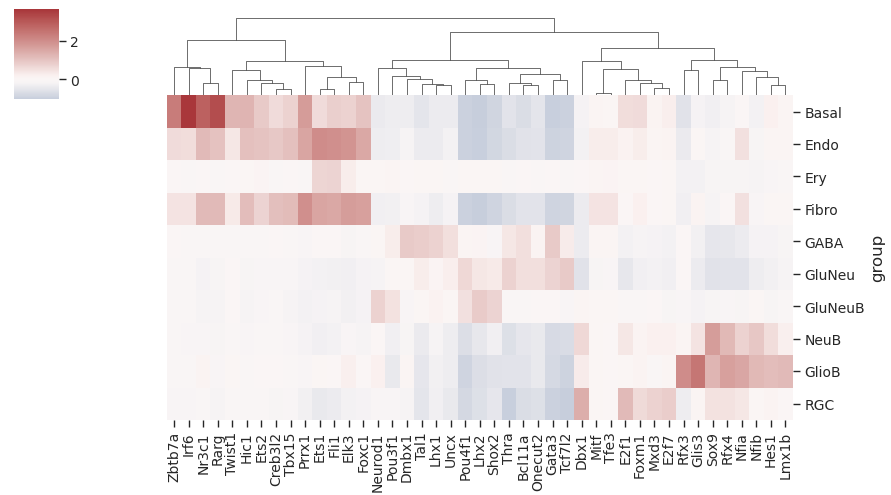

In [63]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    cluster_grid = sns.clustermap(all_auc_mtx_zscore_mean, row_cluster=False,
                                  cmap="vlag", center=0, figsize=(9,5))
    cluster_grid.savefig(f'figures/heatmap_top{RSS_topN}_regulon_activity_across_all_cell_type.pdf')

## within cell type

In [63]:
def subset_auc_matrix(auc_mtx: pd.DataFrame, cats: List[str], adata: ad.AnnData):
    tp_ct_auc_mtx = auc_mtx.loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']],:]
    tp_ct_label_in_all_cell = adata.obs.loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']], 'stage_annot_env_group']
    return (tp_ct_auc_mtx, tp_ct_label_in_all_cell)



In [64]:
def RSS_analysis(cats: List[str], tp_ct_auc_mtx: pd.DataFrame, tp_ct_label_in_all_cell: List[str], time_point: str, cell_type: str, motif_table: pd.DataFrame):
    # get RSS matrix
    rss_cellType = regulon_specificity_scores( tp_ct_auc_mtx, tp_ct_label_in_all_cell )
    
    topreg = {}
    # Draw RSS regulons
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        fig, axes = plt.subplots(1, 2, figsize = (6, 4))
        for index, c in enumerate(cats):
            topreg[c] = list(rss_cellType.T[c].sort_values(ascending=False)[:RSS_topN].index)
            x=rss_cellType.T[c]
            plot_rss(rss_cellType, c, top_n=RSS_topN, max_n=None, ax=axes[index])
            axes[index].set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
            for t in axes[index].texts:
                t.set_fontsize(12)
            adjust_text(axes[index].texts, autoalign='xy', ha='right', va='bottom',
                        arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001,
                        ax = axes[index])

        fig.tight_layout()
        fig.savefig(f'figures/{time_point}_{cell_type}_cell_NT_RSS_top_5.pdf', dpi=600, bbox_inches = "tight")
    
    # output top regulons
    write_top_regulon(top_reg = topreg, name=f'{time_point}_{cell_type}', motif_table = df_motifs_)
    topreg_list = reduce(lambda x, y: list(set(x) | set(y)), topreg.values())
    
    return topreg_list

In [65]:
def draw_mean_activities(time_point: str, cell_type: str, cats: List[str],
                         topreg_list: List[str], auc_mtx_zscore: Dict[str, pd.DataFrame], adata: ad.AnnData):
    # all cells
    tp_ct_auc_mtx_zscore = auc_mtx_zscore['all'].loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']],:][topreg_list]
    tp_ct_auc_mtx_zscore['group'] = pd.Categorical(
    adata.obs.loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']], 'stage_annot_env_group'],
                                                 categories=cats)
    tp_ct_auc_mtx_mean = tp_ct_auc_mtx_zscore.groupby('group').mean()
    
    ## draw
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        cluster_grid = sns.clustermap(tp_ct_auc_mtx_mean, row_cluster=False,
                                      cmap="vlag", center=0, figsize=(9,2))
        cluster_grid.savefig(f'figures/heatmap_regulon_activity_across_{time_point}_{cell_type}_normalized_by_all_cells.pdf')
    
    # cell type specific
    cell_indexes = [True if x in cats else False for x in adata.obs.loc[adata.obs['orig.ident'] == time_point,'stage_annot_env_group']]
    tp_ct_auc_mtx_zscore = auc_mtx_zscore[time_point].loc[cell_indexes,:][topreg_list]
    tp_ct_auc_mtx_zscore['group'] = pd.Categorical(
    adata.obs.loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']], 'stage_annot_env_group'],
                                                 categories=cats)
    tp_ct_auc_mtx_mean = tp_ct_auc_mtx_zscore.groupby('group').mean()
    
    ## draw
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        cluster_grid = sns.clustermap(tp_ct_auc_mtx_mean, row_cluster=False,
                                      cmap="vlag", center=0, figsize=(9,2))
        cluster_grid.savefig(f'figures/heatmap_regulon_activity_across_{time_point}_{cell_type}_normalized_by_timepoint.pdf')
    
    
    

In [55]:
def wtihin_cell_type_analysis(time_point: str,
                              cell_type: str,
                              RSS_topN: int = 5,
                              auc_mtx: pd.DataFrame = auc_mtx,
                              adata: ad.AnnData = adata,
                              motif_table: pd.DataFrame = df_motifs_,
                              auc_mtx_zscore_dict: Dict[str, pd.DataFrame] = auc_mtx_zscore_dict

                             ):
    cats = [f'{time_point}_{cell_type}_low', f'{time_point}_{cell_type}_high']
    tp_ct_auc_mtx, tp_ct_label_in_all_cell = subset_auc_matrix(auc_mtx, cats, adata)
    topreg_list = RSS_analysis(cats, tp_ct_auc_mtx, tp_ct_label_in_all_cell, time_point, cell_type, motif_table = df_motifs_)
    draw_mean_activities(time_point, cell_type, cats, topreg_list, auc_mtx_zscore = auc_mtx_zscore_dict, adata = adata)

/tmp/ipykernel_9008/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


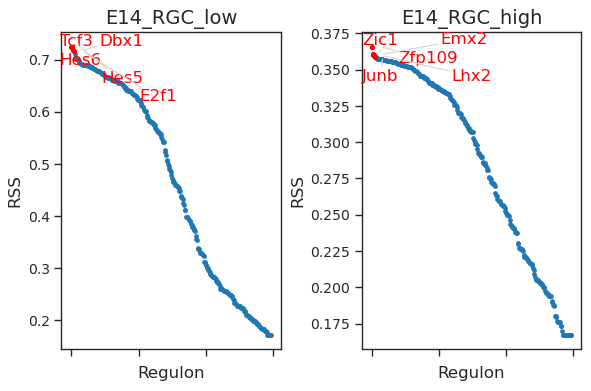

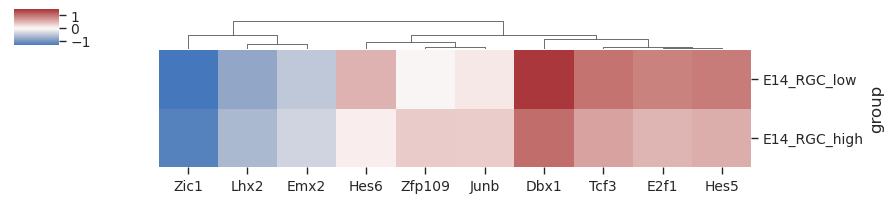

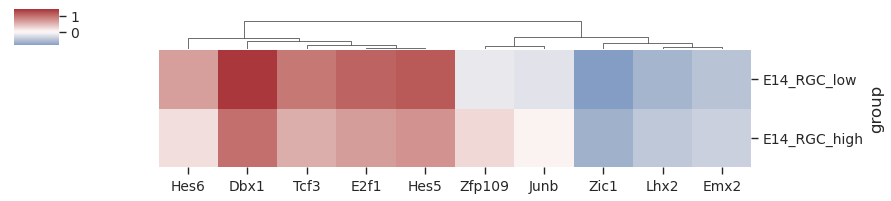

In [68]:
wtihin_cell_type_analysis('E14', 'RGC')

/tmp/ipykernel_9008/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


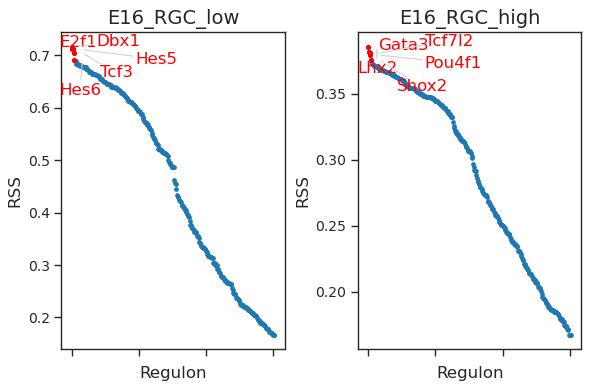

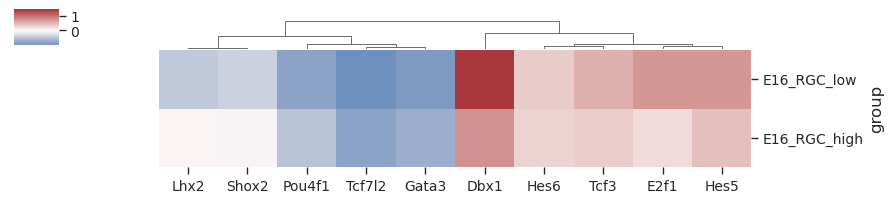

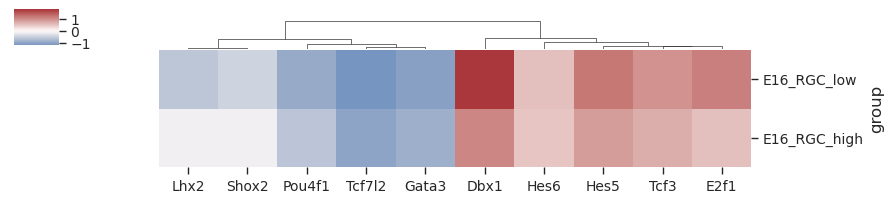

In [69]:
wtihin_cell_type_analysis('E16', 'RGC')

/tmp/ipykernel_9008/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


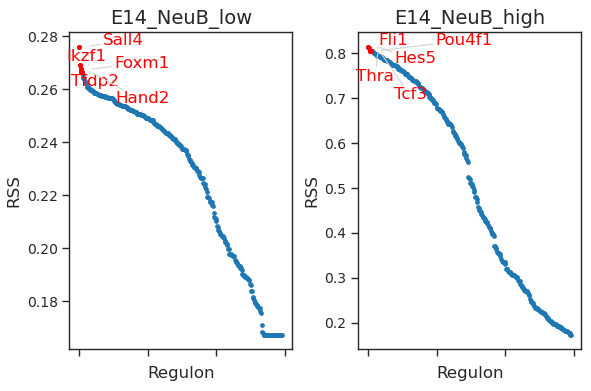

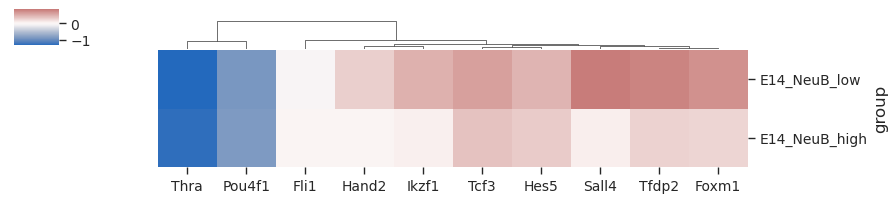

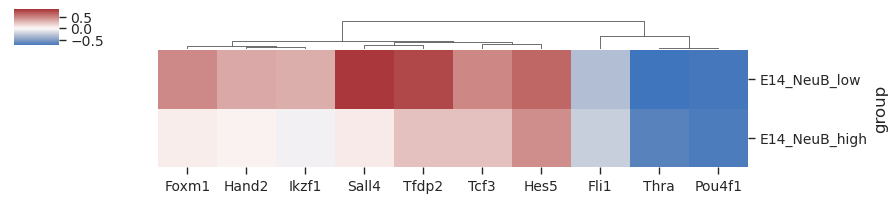

In [70]:
wtihin_cell_type_analysis('E14', 'NeuB')

/tmp/ipykernel_9008/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


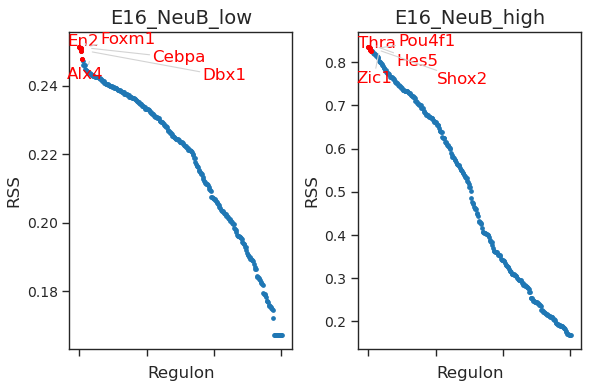

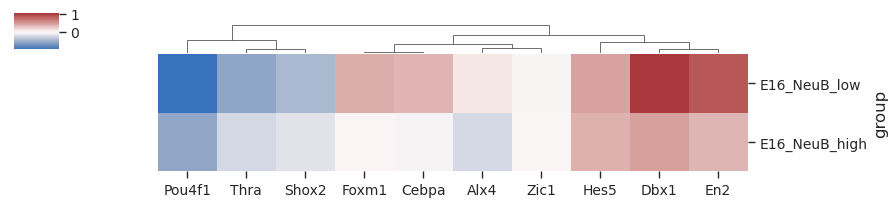

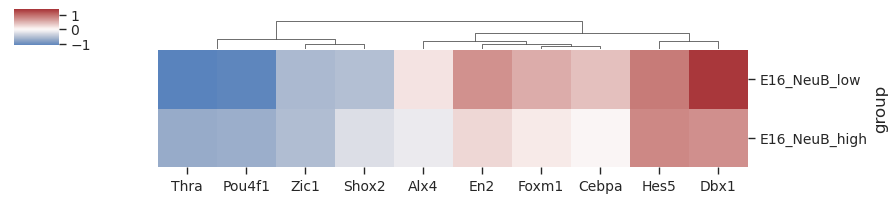

In [71]:
wtihin_cell_type_analysis('E16', 'NeuB')

/tmp/ipykernel_9008/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


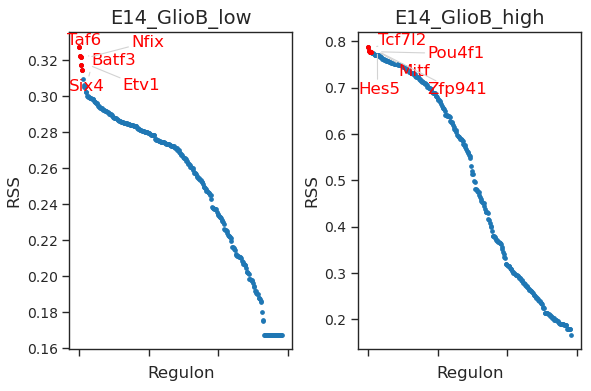

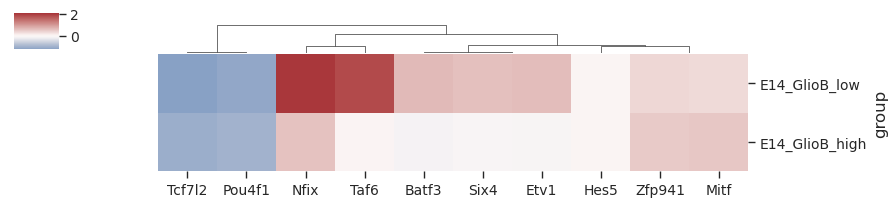

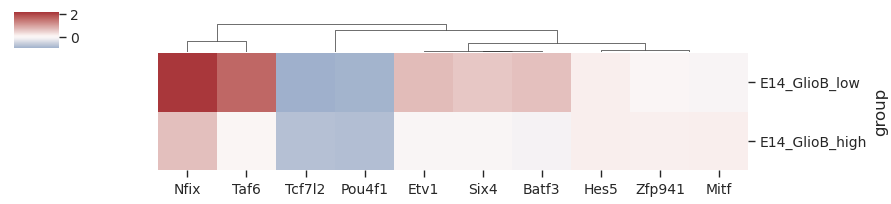

In [72]:
wtihin_cell_type_analysis('E14', 'GlioB')

/tmp/ipykernel_9008/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


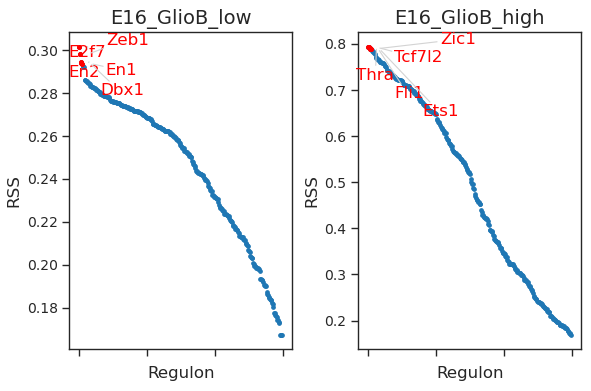

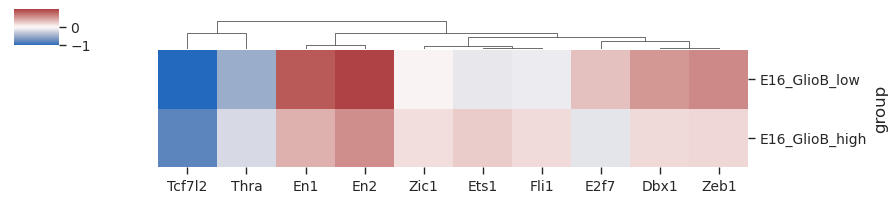

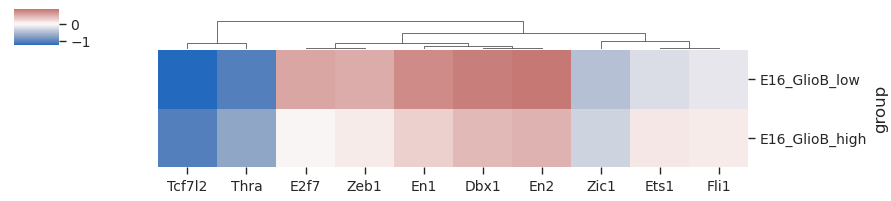

In [73]:
wtihin_cell_type_analysis('E16', 'GlioB')

# High RGC proximity

In [100]:
def subset_auc_matrix_group_key(auc_mtx: pd.DataFrame, cats: List[str], adata: ad.AnnData, group_key: str):
    tp_ct_auc_mtx = auc_mtx.loc[[True if x in cats else False for x in adata.obs[group_key]],:]
    tp_ct_label_in_all_cell = adata.obs.loc[[True if x in cats else False for x in adata.obs[group_key]], group_key]
    return (tp_ct_auc_mtx, tp_ct_label_in_all_cell)


In [101]:
def RSS_analysis_env(cats: List[str],
                     tp_ct_auc_mtx: pd.DataFrame,
                     tp_ct_label_in_all_cell: List[str],
                     time_point: str,
                     cell_type: str,
                     env_status: str,
                     motif_table: pd.DataFrame):
    # get RSS matrix
    rss_cellType = regulon_specificity_scores( tp_ct_auc_mtx, tp_ct_label_in_all_cell )
    
    topreg = {}
    # Draw RSS regulons
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        fig, axes = plt.subplots(1, 2, figsize = (6, 4))
        for index, c in enumerate(cats):
            topreg[c] = list(rss_cellType.T[c].sort_values(ascending=False)[:RSS_topN].index)
            x=rss_cellType.T[c]
            plot_rss(rss_cellType, c, top_n=RSS_topN, max_n=None, ax=axes[index])
            axes[index].set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
            for t in axes[index].texts:
                t.set_fontsize(12)
            adjust_text(axes[index].texts, autoalign='xy', ha='right', va='bottom',
                        arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001,
                        ax = axes[index])

        fig.tight_layout()
        fig.savefig(f'figures/{time_point}_{cell_type}_{env_status}_cell_NT_RSS_top_5.pdf', dpi=600, bbox_inches = "tight")
    
    # output top regulons
    write_top_regulon(top_reg = topreg, name=f'{time_point}_{cell_type}', motif_table = df_motifs_)
    topreg_list = reduce(lambda x, y: list(set(x) | set(y)), topreg.values())
    
    return topreg_list

In [102]:
def draw_mean_activities_group_key(time_point: str,
                                   cell_type: str,
                                   env_status: str,
                                   cats: List[str],
                                   topreg_list: List[str],
                                   auc_mtx_zscore: Dict[str, pd.DataFrame],
                                   adata: ad.AnnData,
                                   group_key: str):
    # all cells
    tp_ct_auc_mtx_zscore = auc_mtx_zscore['all'].loc[[True if x in cats else False for x in adata.obs[group_key]],:][topreg_list]
    tp_ct_auc_mtx_zscore['group'] = pd.Categorical(
    adata.obs.loc[[True if x in cats else False for x in adata.obs[group_key]], group_key],
                                                 categories=cats)
    tp_ct_auc_mtx_mean = tp_ct_auc_mtx_zscore.groupby('group').mean()
    
    ## draw
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        cluster_grid = sns.clustermap(tp_ct_auc_mtx_mean, row_cluster=False,
                                      cmap="vlag", center=0, figsize=(9,5))
        cluster_grid.savefig(f'figures/heatmap_regulon_activity_across_{time_point}_{cell_type}_{env_status}_normalized_by_all_cells.pdf')
    
    # cell type specific
    cell_indexes = [True if x in cats else False for x in adata.obs.loc[adata.obs['orig.ident'] == time_point,group_key]]
    tp_ct_auc_mtx_zscore = auc_mtx_zscore[time_point].loc[cell_indexes,:][topreg_list]
    tp_ct_auc_mtx_zscore['group'] = pd.Categorical(
    adata.obs.loc[[True if x in cats else False for x in adata.obs[group_key]], group_key],
                                                 categories=cats)
    tp_ct_auc_mtx_mean = tp_ct_auc_mtx_zscore.groupby('group').mean()
    
    ## draw
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        cluster_grid = sns.clustermap(tp_ct_auc_mtx_mean, row_cluster=False,
                                      cmap="vlag", center=0, figsize=(9,5))
        cluster_grid.savefig(f'figures/heatmap_regulon_activity_across_{time_point}_{cell_type}_{env_status}_normalized_by_timepoint.pdf')
    
    
    

# E14 High NeuB RGC proximity

In [74]:
time_point = 'E14'
cell_type = 'NeuB'
env_status = 'high'
RSS_topN = 5
auc_mtx: pd.DataFrame = auc_mtx
adata: ad.AnnData = adata
motif_table: pd.DataFrame = df_motifs_
auc_mtx_zscore_dict: Dict[str, pd.DataFrame] = auc_mtx_zscore_dict
group_key = 'stage_annot_env_rgc_proximal'

In [75]:
cats = [f'{time_point}_{cell_type}_{env_status}_RGC_proximal',
        f'{time_point}_{cell_type}_{env_status}_RGC_far']

In [76]:
tp_ct_auc_mtx, tp_ct_label_in_all_cell = subset_auc_matrix_group_key(auc_mtx, cats, adata, group_key)

/tmp/ipykernel_233415/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


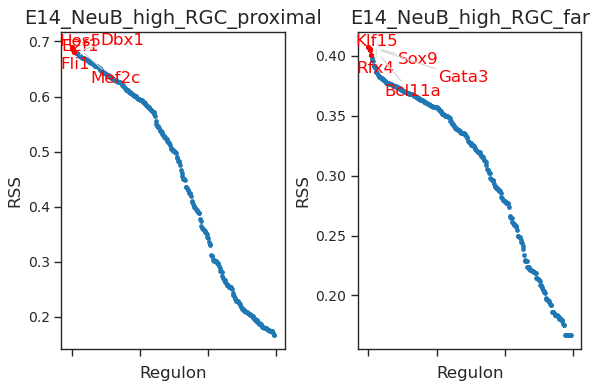

In [77]:
topreg_list = RSS_analysis_env(cats, tp_ct_auc_mtx, tp_ct_label_in_all_cell, time_point, cell_type, env_status, motif_table = df_motifs_)

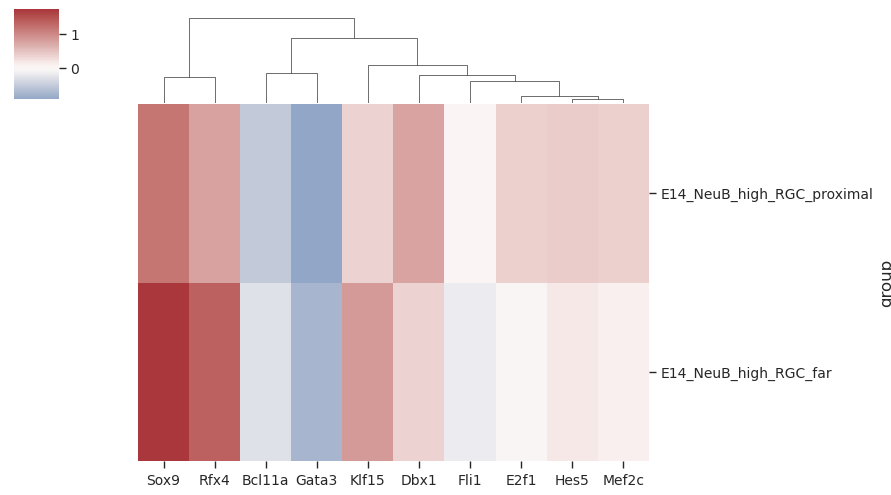

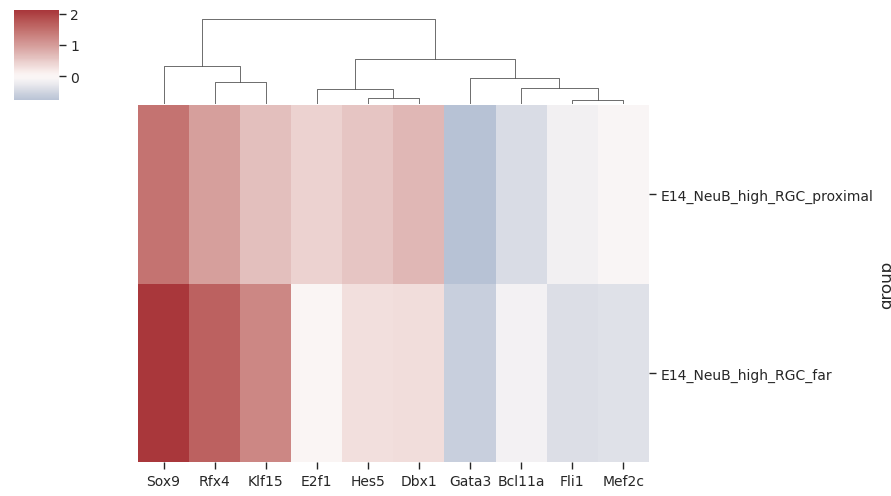

In [78]:
draw_mean_activities_group_key(time_point,
                               cell_type,
                               env_status,
                               cats,
                               topreg_list,
                               auc_mtx_zscore = auc_mtx_zscore_dict,
                               adata = adata,
                               group_key = group_key)

# E14 High GlioB RGC proximity

In [55]:
time_point = 'E14'
cell_type = 'GlioB'
env_status = 'high'
RSS_topN = 5
auc_mtx: pd.DataFrame = auc_mtx
adata: ad.AnnData = adata
motif_table: pd.DataFrame = df_motifs_
auc_mtx_zscore_dict: Dict[str, pd.DataFrame] = auc_mtx_zscore_dict
group_key = 'stage_annot_env_rgc_proximal'

In [56]:
cats = [f'{time_point}_{cell_type}_{env_status}_RGC_proximal',
        f'{time_point}_{cell_type}_{env_status}_RGC_far']

In [57]:
tp_ct_auc_mtx, tp_ct_label_in_all_cell = subset_auc_matrix_group_key(auc_mtx, cats, adata, group_key)

/tmp/ipykernel_49196/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


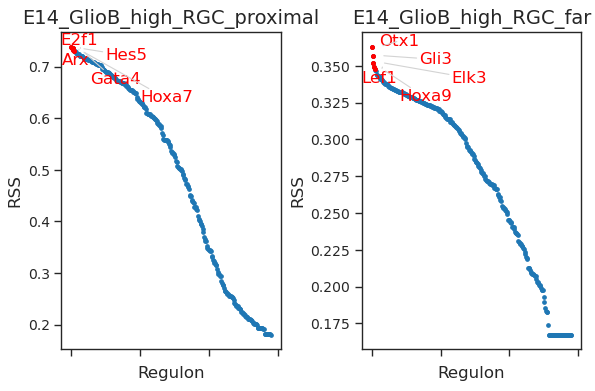

In [58]:
topreg_list = RSS_analysis_env(cats, tp_ct_auc_mtx, tp_ct_label_in_all_cell, time_point, cell_type, env_status, motif_table = df_motifs_)

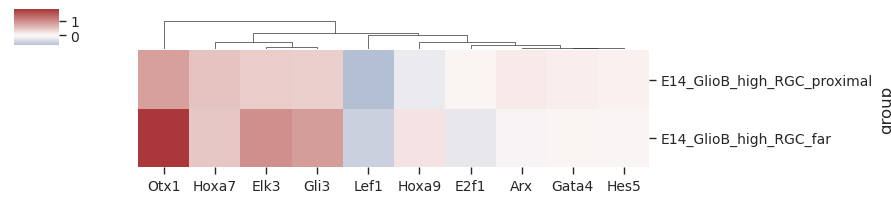

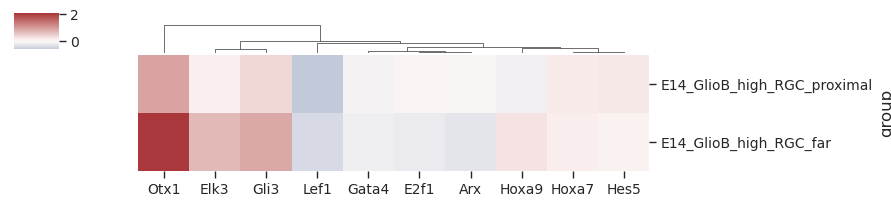

In [122]:
draw_mean_activities_group_key(time_point,
                               cell_type,
                               env_status,
                               cats,
                               topreg_list,
                               auc_mtx_zscore = auc_mtx_zscore_dict,
                               adata = adata,
                               group_key = group_key)

# E14 RGC, GlioB, NeuB

In [138]:
def RSS_analysis_(cats: List[str], tp_ct_auc_mtx: pd.DataFrame, tp_ct_label_in_all_cell: List[str], time_point: str, cell_type: str, motif_table: pd.DataFrame):
    # get RSS matrix
    rss_cellType = regulon_specificity_scores( tp_ct_auc_mtx, tp_ct_label_in_all_cell )
    
    topreg = {}
    # Draw RSS regulons
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        fig, axes = plt.subplots(len(cats) // 2, 2, figsize = (6, 4 * len(cats) // 2))
        for index, c in enumerate(cats):
            ax = axes[index// 2, index % 2]
            topreg[c] = list(rss_cellType.T[c].sort_values(ascending=False)[:RSS_topN].index)
            x=rss_cellType.T[c]
            plot_rss(rss_cellType, c, top_n=RSS_topN, max_n=None, ax=ax)
            ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
            for t in ax.texts:
                t.set_fontsize(12)
            adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom',
                        arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001,
                        ax = ax)

        fig.tight_layout()
        fig.savefig(f'figures/{time_point}_{cell_type}_cell_NT_RSS_top_5.pdf', dpi=600, bbox_inches = "tight")
    
    # output top regulons
    write_top_regulon(top_reg = topreg, name=f'{time_point}_{cell_type}', motif_table = df_motifs_)
    topreg_list = reduce(lambda x, y: x.extend(y), topreg.values())
    
    return topreg_list

In [139]:
def draw_mean_activities(time_point: str, cell_type: str, cats: List[str],
                         topreg_list: List[str], auc_mtx_zscore: Dict[str, pd.DataFrame], adata: ad.AnnData):
    # all cells
    # tp_ct_auc_mtx_zscore = auc_mtx_zscore['all'].loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']],:][topreg_list]
    # tp_ct_auc_mtx_zscore['group'] = pd.Categorical(
    # adata.obs.loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']], 'stage_annot_env_group'],
    #                                              categories=cats)
    # tp_ct_auc_mtx_mean = tp_ct_auc_mtx_zscore.groupby('group').mean()
    # 
    # ## draw
    # with sns.axes_style('white', rc={
    #         'xtick.bottom': True,
    #         'ytick.left': True
    # }), sns.plotting_context('paper',
    #                          rc={
    #                              'axes.titlesize': 14,
    #                              'axes.labelsize': 12,
    #                              'xtick.labelsize': 10,
    #                              'ytick.labelsize': 10,
    #                              'legend.fontsize': 10
    #                          }):
    #     fig, ax = plt.subplots(figsize=(20,5))
    #     sns.heatmap(tp_ct_auc_mtx_mean, cmap="vlag", center=0, ax=ax)
    #     fig.tight_layout()
    #     fig.savefig(f'figures/heatmap_regulon_activity_across_{time_point}_{cell_type}_normalized_by_all_cells.pdf')
    
    # cell type specific
    cell_indexes = [True if x in cats else False for x in adata.obs.loc[adata.obs['orig.ident'] == time_point,'stage_annot_env_group']]
    tp_ct_auc_mtx_zscore = auc_mtx_zscore[time_point].loc[cell_indexes,:][topreg_list]
    tp_ct_auc_mtx_zscore['group'] = pd.Categorical(
    adata.obs.loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']], 'stage_annot_env_group'],
                                                 categories=cats)
    tp_ct_auc_mtx_mean = tp_ct_auc_mtx_zscore.groupby('group').mean()
    
    ## draw
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        fig, ax = plt.subplots(figsize=(20,5))
        row_order = ['E14_NeuB high', 'E14_NeuB low', 'E14_GlioB high', 'E14_GlioB low', 'E14_RGC high', 'E14_RGC low', ]
        sns.heatmap(tp_ct_auc_mtx_mean.loc[row_order], cmap="vlag", center=0, ax=ax)
        fig.tight_layout()
        fig.savefig(f'figures/heatmap_regulon_activity_across_{time_point}_{cell_type}_normalized_by_timepoint.pdf')
    
    
    

In [226]:
RSS_topN: int = 10
auc_mtx: pd.DataFrame = auc_mtx
adata: ad.AnnData = adata
motif_table: pd.DataFrame = df_motifs_
auc_mtx_zscore_dict: Dict[str, pd.DataFrame] = auc_mtx_zscore_dict

time_point = 'E14'
cell_type = 'RGN'



# cats = [f'{time_point}_RGC_low', f'{time_point}_RGC_high'] + [f'{time_point}_GlioB_low', f'{time_point}_GlioB_high'] + [f'{time_point}_NeuB_low', f'{time_point}_NeuB_high']
# tp_ct_auc_mtx, tp_ct_label_in_all_cell = subset_auc_matrix(auc_mtx, cats, adata)
# topreg_list = RSS_analysis_(cats, tp_ct_auc_mtx, tp_ct_label_in_all_cell, time_point, cell_type, motif_table = df_motifs_)
# draw_mean_activities(time_point, cell_type, cats, topreg_list, auc_mtx_zscore = auc_mtx_zscore_dict, adata = adata)

In [227]:
cats = [f'{time_point}_RGC_low', f'{time_point}_RGC_high'] + [f'{time_point}_GlioB_low', f'{time_point}_GlioB_high'] + [f'{time_point}_NeuB_low', f'{time_point}_NeuB_high']
cats = cats[::-1]

In [228]:
cats

['E14_NeuB_high',
 'E14_NeuB_low',
 'E14_GlioB_high',
 'E14_GlioB_low',
 'E14_RGC_high',
 'E14_RGC_low']

In [229]:
tp_ct_auc_mtx, tp_ct_label_in_all_cell = subset_auc_matrix(auc_mtx, cats, adata)

/tmp/ipykernel_18738/2888893865.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  for i in motif_table.loc[regulon,'TargetGenes'].values:


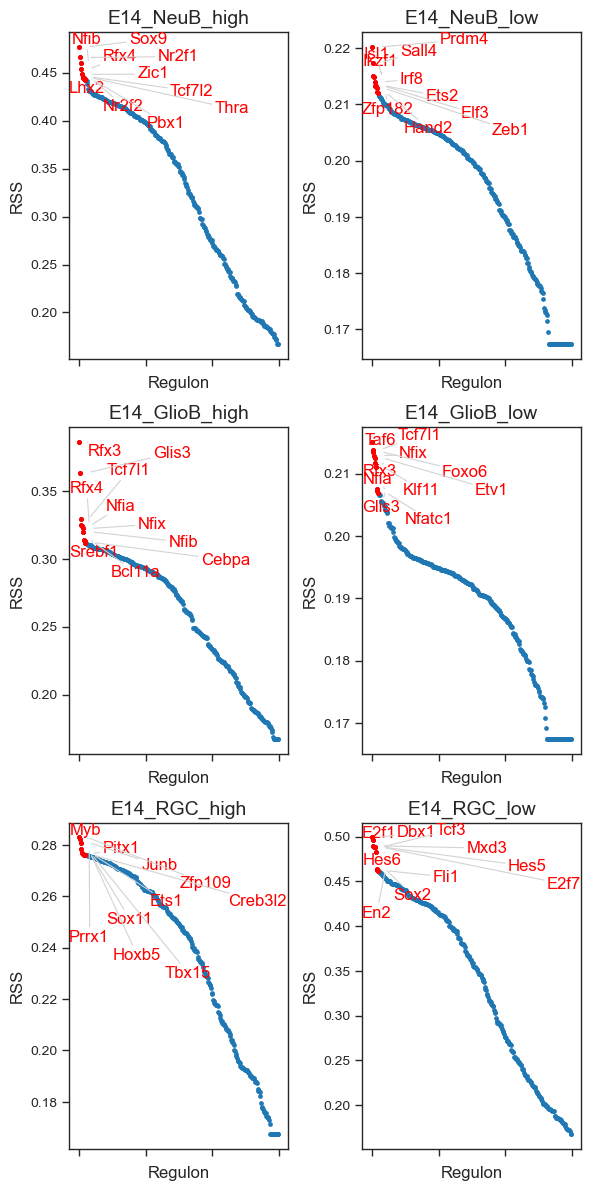

In [230]:
rss_cellType = regulon_specificity_scores( tp_ct_auc_mtx, tp_ct_label_in_all_cell )

RSS_topN_dict = {'E14_RGC_low': 10,
                 'E14_RGC_high': 10,
                 'E14_GlioB_low': 10,
                 'E14_GlioB_high': 10,
                 'E14_NeuB_low': 10,
                 'E14_NeuB_high': 10
                }

topreg = {}
topreg_list = []
# Draw RSS regulons
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, axes = plt.subplots(len(cats) // 2, 2, figsize = (6, 4 * len(cats) // 2))
    for index, c in enumerate(cats):
        ax = axes[index// 2, index % 2]
        topreg[c] = list(rss_cellType.T[c].sort_values(ascending=False)[:RSS_topN_dict[c]].index)
        topreg_list.extend(list(rss_cellType.T[c].sort_values(ascending=False)[:RSS_topN_dict[c]].index))
        x=rss_cellType.T[c]
        plot_rss(rss_cellType, c, top_n=RSS_topN_dict[c], max_n=None, ax=ax)
        ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
        for t in ax.texts:
            t.set_fontsize(12)
        adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom',
                    arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001,
                    ax = ax)

    fig.tight_layout()
    fig.savefig(f'figures/{time_point}_{cell_type}_cell_NT_RSS_top_5.pdf', dpi=600, bbox_inches = "tight")

# output top regulons
write_top_regulon(top_reg = topreg, name=f'{time_point}_{cell_type}', motif_table = df_motifs_)




In [231]:
topreg

{'E14_NeuB_high': ['Sox9',
  'Nr2f1',
  'Nfib',
  'Rfx4',
  'Zic1',
  'Tcf7l2',
  'Thra',
  'Lhx2',
  'Nr2f2',
  'Pbx1'],
 'E14_NeuB_low': ['Prdm4',
  'Sall4',
  'Isl1',
  'Ikzf1',
  'Irf8',
  'Ets2',
  'Elf3',
  'Zeb1',
  'Zfp182',
  'Hand2'],
 'E14_GlioB_high': ['Rfx3',
  'Glis3',
  'Tcf7l1',
  'Rfx4',
  'Nfia',
  'Nfix',
  'Nfib',
  'Srebf1',
  'Bcl11a',
  'Cebpa'],
 'E14_GlioB_low': ['Taf6',
  'Tcf7l1',
  'Foxo6',
  'Nfix',
  'Etv1',
  'Rfx3',
  'Klf11',
  'Nfia',
  'Glis3',
  'Nfatc1'],
 'E14_RGC_high': ['Zfp109',
  'Myb',
  'Junb',
  'Prrx1',
  'Sox11',
  'Hoxb5',
  'Pitx1',
  'Tbx15',
  'Creb3l2',
  'Ets1'],
 'E14_RGC_low': ['Dbx1',
  'E2f1',
  'Mxd3',
  'Tcf3',
  'Hes5',
  'E2f7',
  'Hes6',
  'Sox2',
  'En2',
  'Fli1']}

In [165]:
topreg_list

['Sox9',
 'Nr2f1',
 'Nfib',
 'Rfx4',
 'Zic1',
 'Prdm4',
 'Sall4',
 'Isl1',
 'Ikzf1',
 'Irf8',
 'Rfx3',
 'Glis3',
 'Tcf7l1',
 'Rfx4',
 'Nfia',
 'Taf6',
 'Tcf7l1',
 'Foxo6',
 'Nfix',
 'Etv1',
 'Zfp109',
 'Myb',
 'Junb',
 'Prrx1',
 'Sox11',
 'Dbx1',
 'E2f1',
 'Mxd3',
 'Tcf3',
 'Hes5']

In [250]:
topreg_list = ['Dbx1', 'E2f1', # RGC-specific
               'Hes6', 'En2',# RGC low specific
               'Zfp109', 'Junb', # RGC high specific
               
               'Glis3', 'Rfx3',  # GlioB-specific
               'Taf6','Foxo6',# GlioB low specific
               'Srebf1',  # GlioB high specific
               
               'Sox9','Rfx4',# NeuB-specific
               'Prdm4','Sall4',# NeuB low specific
                'Sox1', 'Hes1', # NeuB high specific
               ]

In [168]:
topreg_set = set()

with open('All_cells_top30_top_regulon_by_condition.txt') as fhd:
    for line in fhd:
        line = line.strip().split()
        if line[0] in ['RGC', 'GlioB', 'NeuB']:
            for x in line[1:]:
                topreg_set.add(x)
            


topreg_list = sorted(list(topreg_set))

In [169]:
print(len(topreg_list))
print(len(set(topreg_list)))

52
52


In [170]:
# draw_mean_activities(time_point, cell_type, cats, topreg_list, auc_mtx_zscore = auc_mtx_zscore_dict, adata = adata)

In [251]:
cell_indexes = [True if x in cats else False for x in adata.obs.loc[adata.obs['orig.ident'] == time_point,'stage_annot_env_group']]
tp_ct_auc_mtx_zscore = auc_mtx_zscore_dict[time_point].loc[cell_indexes,:][topreg_list]
tp_ct_auc_mtx_zscore['group'] = pd.Categorical(
adata.obs.loc[[True if x in cats else False for x in adata.obs['stage_annot_env_group']], 'stage_annot_env_group'],
                                             categories=cats)
tp_ct_auc_mtx_mean = tp_ct_auc_mtx_zscore.groupby('group').mean()

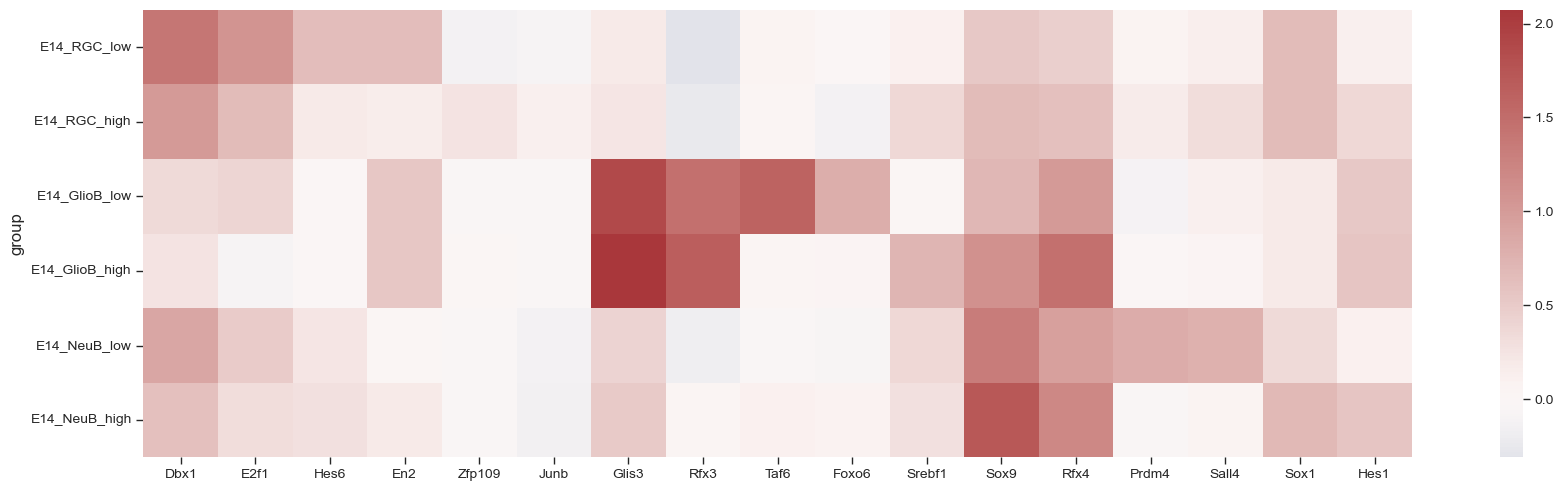

In [256]:
## draw
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize=(18,5))
    sns.heatmap(tp_ct_auc_mtx_mean.iloc[::-1], cmap="vlag", center=0, ax=ax)
    ax.set_aspect('equal', adjustable='box')
    fig.tight_layout()
    fig.savefig(f'figures/heatmap_regulon_activity_across_{time_point}_{cell_type}_normalized_by_timepoint.pdf')